# Debugging Feature Initialization

In [1]:
import numpy as np
import torch

import pyro
import pyro.poutine as poutine
from pyro.contrib.tabular import TreeCat
from pyro.optim import Adam
from treecat_exp.preprocess import load_data, partition_data
from treecat_exp.util import TRAIN

np.set_printoptions(precision=4)
pyro.set_rng_seed(1)
pyro.get_param_store().clear()
pyro.enable_validation(True)

from matplotlib import pyplot
%matplotlib inline
%config InlineBackend.rc = {'figure.facecolor': (1, 1, 1, 1)}
# %config InlineBackend.figure_format = 'svg'

In [19]:
args = type("Args", (), {})
args.dataset = "housing"
args.max_num_rows = 9999999999
args.capacity = 8
args.init_size = 1024

Load data.

In [20]:
features, data, mask = load_data(args)
num_rows = len(data[0])
num_cells = num_rows * len(features)
print("loaded {} rows x {} features = {} cells".format(
      num_rows, len(features), num_cells))
print("\n".join(["Features:"] + [str(f) for f in features]))

loaded 506 rows x 14 features = 7084 cells
Features:
Real("CRIM")
Real("ZN")
Real("INDUS")
Boolean("CHAS")
Real("NOX")
Real("RM")
Real("AGE")
Real("DIS")
Real("RAD")
Real("TAX")
Real("PTRATIO")
Real("B")
Real("LSTAT")
Real("MEDV")


Initialize the model.

In [21]:
pyro.get_param_store().clear()
model = TreeCat(features, args.capacity)
trainer = model.trainer("map", optim=Adam({}))
for batch_data, batch_mask in partition_data(data, mask, args.init_size):
    break
trainer.init(batch_data, batch_mask)
model.guide(batch_data, batch_mask)  # initializes groups
print("\n".join("{} = {}".format(key, value.data.cpu().numpy())
                for key, value in sorted(pyro.get_param_store().items())))

auto_AGE_group_loc = [ 71.2081  12.8686  69.5031  99.5879 101.3615  94.4573 112.3038  47.254 ]
auto_AGE_group_scale = [11.4248  8.545   9.242  11.7509  7.7171  9.3088 11.7752 13.6038]
auto_AGE_shared_loc_loc = 6.628698825836182
auto_AGE_shared_loc_scale = 7.389056205749512
auto_AGE_shared_scale_loc = 2.336517810821533
auto_AGE_shared_scale_scale = 1.0
auto_B_group_loc = [402.6597 302.392  371.7465 338.0716 371.5084 361.856  392.8575 465.3603]
auto_B_group_scale = [29.0202 43.5442 24.6695 20.7127 42.612  52.7053 18.5164 23.2769]
auto_B_shared_loc_loc = 10.630393028259277
auto_B_shared_loc_scale = 7.389056205749512
auto_B_shared_scale_loc = 3.5131053924560547
auto_B_shared_scale_scale = 1.0
auto_CHAS_group_logits = [-2.1631 -2.6583 -2.2643 -2.2015 -2.3025 -2.3982 -1.6853 -2.1921]
auto_CHAS_shared_loc = -2.4728081226348877
auto_CHAS_shared_scale = 1.0
auto_CRIM_group_loc = [  0.4727   4.8795 -12.573   -2.1453  -7.0139 -11.9272   8.5122   8.7151]
auto_CRIM_group_scale = [2.7499 2.6589 4.13

In [22]:
@torch.no_grad()
def plot_feature(name):
    (f, col), = [(f, col) for f, col in zip(features, batch_data) if f.name == name]
    guide_trace = poutine.trace(model.guide).get_trace(batch_data, batch_mask)
    with poutine.replay(trace=guide_trace):
        shared = f.sample_shared()
        with pyro.plate("components", args.capacity):
            group = f.sample_group(shared)

    print("data mean = {:0.3g}, std = {:0.3g}".format(col.float().mean(),
                                                      col.float().std()))
    print("\n".join("{} = {}".format(key, value.data.cpu().numpy())
                    for key, value in sorted(pyro.get_param_store().items())
                    if key.startswith("auto_{}_".format(name))))

    pyplot.figure(figsize=(9, 6), dpi=300)
    pyplot.hist(col.numpy(), alpha=0.3, label='data', bins=20, density=True)
    datatype = type(f).__name__
    if datatype == "Real":
        x0 = col.min().item()
        x1 = col.max().item()
        X = torch.linspace(x0, x1, 100)
    elif datatype == "Discrete":
        X = torch.arange(f.cardinality)
    else:
        raise ValueError(type(f))
    for i in range(args.capacity):
        d = f.value_dist(group, i)
        Y = d.log_prob(X).exp().numpy()
        if datatype == "Real":
            pyplot.plot(X.numpy(), Y,
                        label='loc={:0.2g}, scale={:0.2g}'.format(d.loc, d.scale))
        else:
            pyplot.plot(X.numpy(), Y)
    pyplot.title(name)
    pyplot.legend(loc='best')
    pyplot.tight_layout()

data mean = 68.6, std = 28.1
auto_AGE_group_loc = [ 71.2081  12.8686  69.5031  99.5879 101.3615  94.4573 112.3038  47.254 ]
auto_AGE_group_scale = [11.4248  8.545   9.242  11.7509  7.7171  9.3088 11.7752 13.6038]
auto_AGE_shared_loc_loc = 6.628698825836182
auto_AGE_shared_loc_scale = 7.389056205749512
auto_AGE_shared_scale_loc = 2.336517810821533
auto_AGE_shared_scale_scale = 1.0


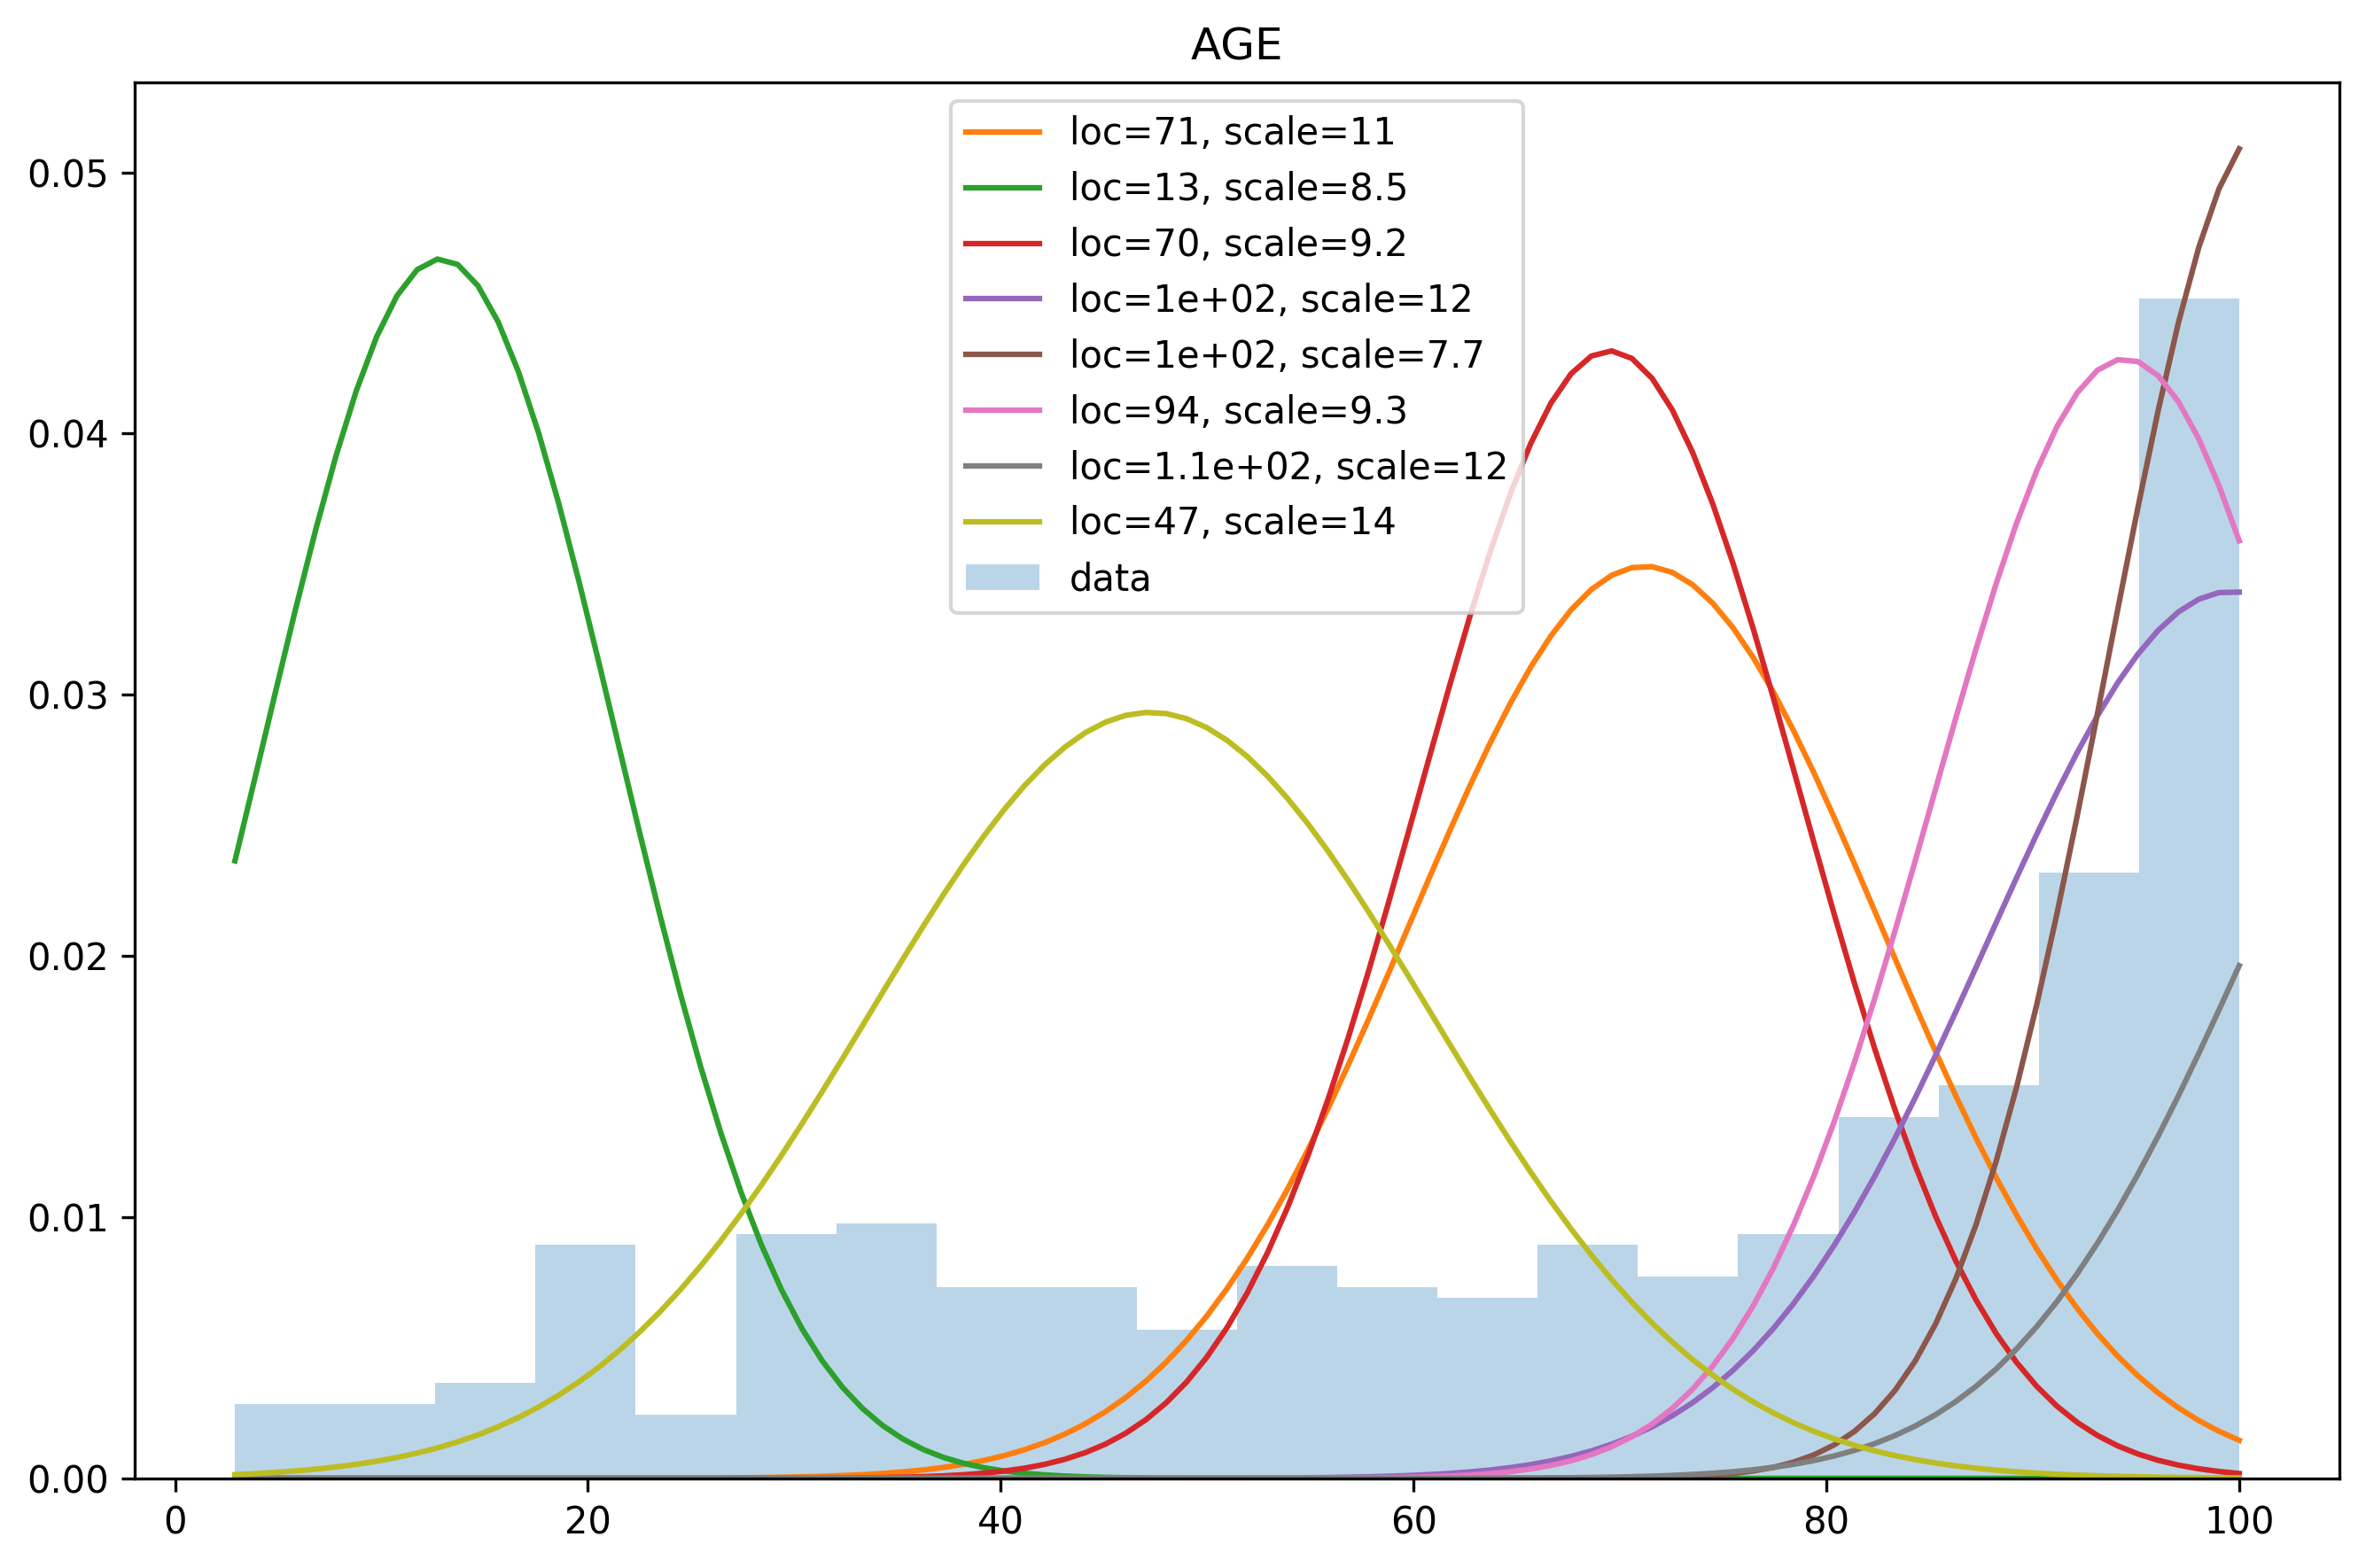

In [23]:
FEATURE = "AGE"
plot_feature(FEATURE)

Now load the trained model.

In [24]:
pyro.get_param_store().load("results/train/{}.treecat.{}.nuts.model.pyro"
                            .format(args.dataset, args.capacity))

data mean = 68.6, std = 28.1
auto_AGE_group_loc = [ 58.9311 114.1749  58.966   91.0587  82.9956  44.4766  84.5873  79.7347]
auto_AGE_group_scale = [11.241   9.0124 14.6073  6.0488  9.6576 21.2162  9.122  26.5738]
auto_AGE_shared_loc_loc = 6.072936534881592
auto_AGE_shared_loc_scale = 5.14423942565918
auto_AGE_shared_scale_loc = 2.2546489238739014
auto_AGE_shared_scale_scale = 1.1611071825027466


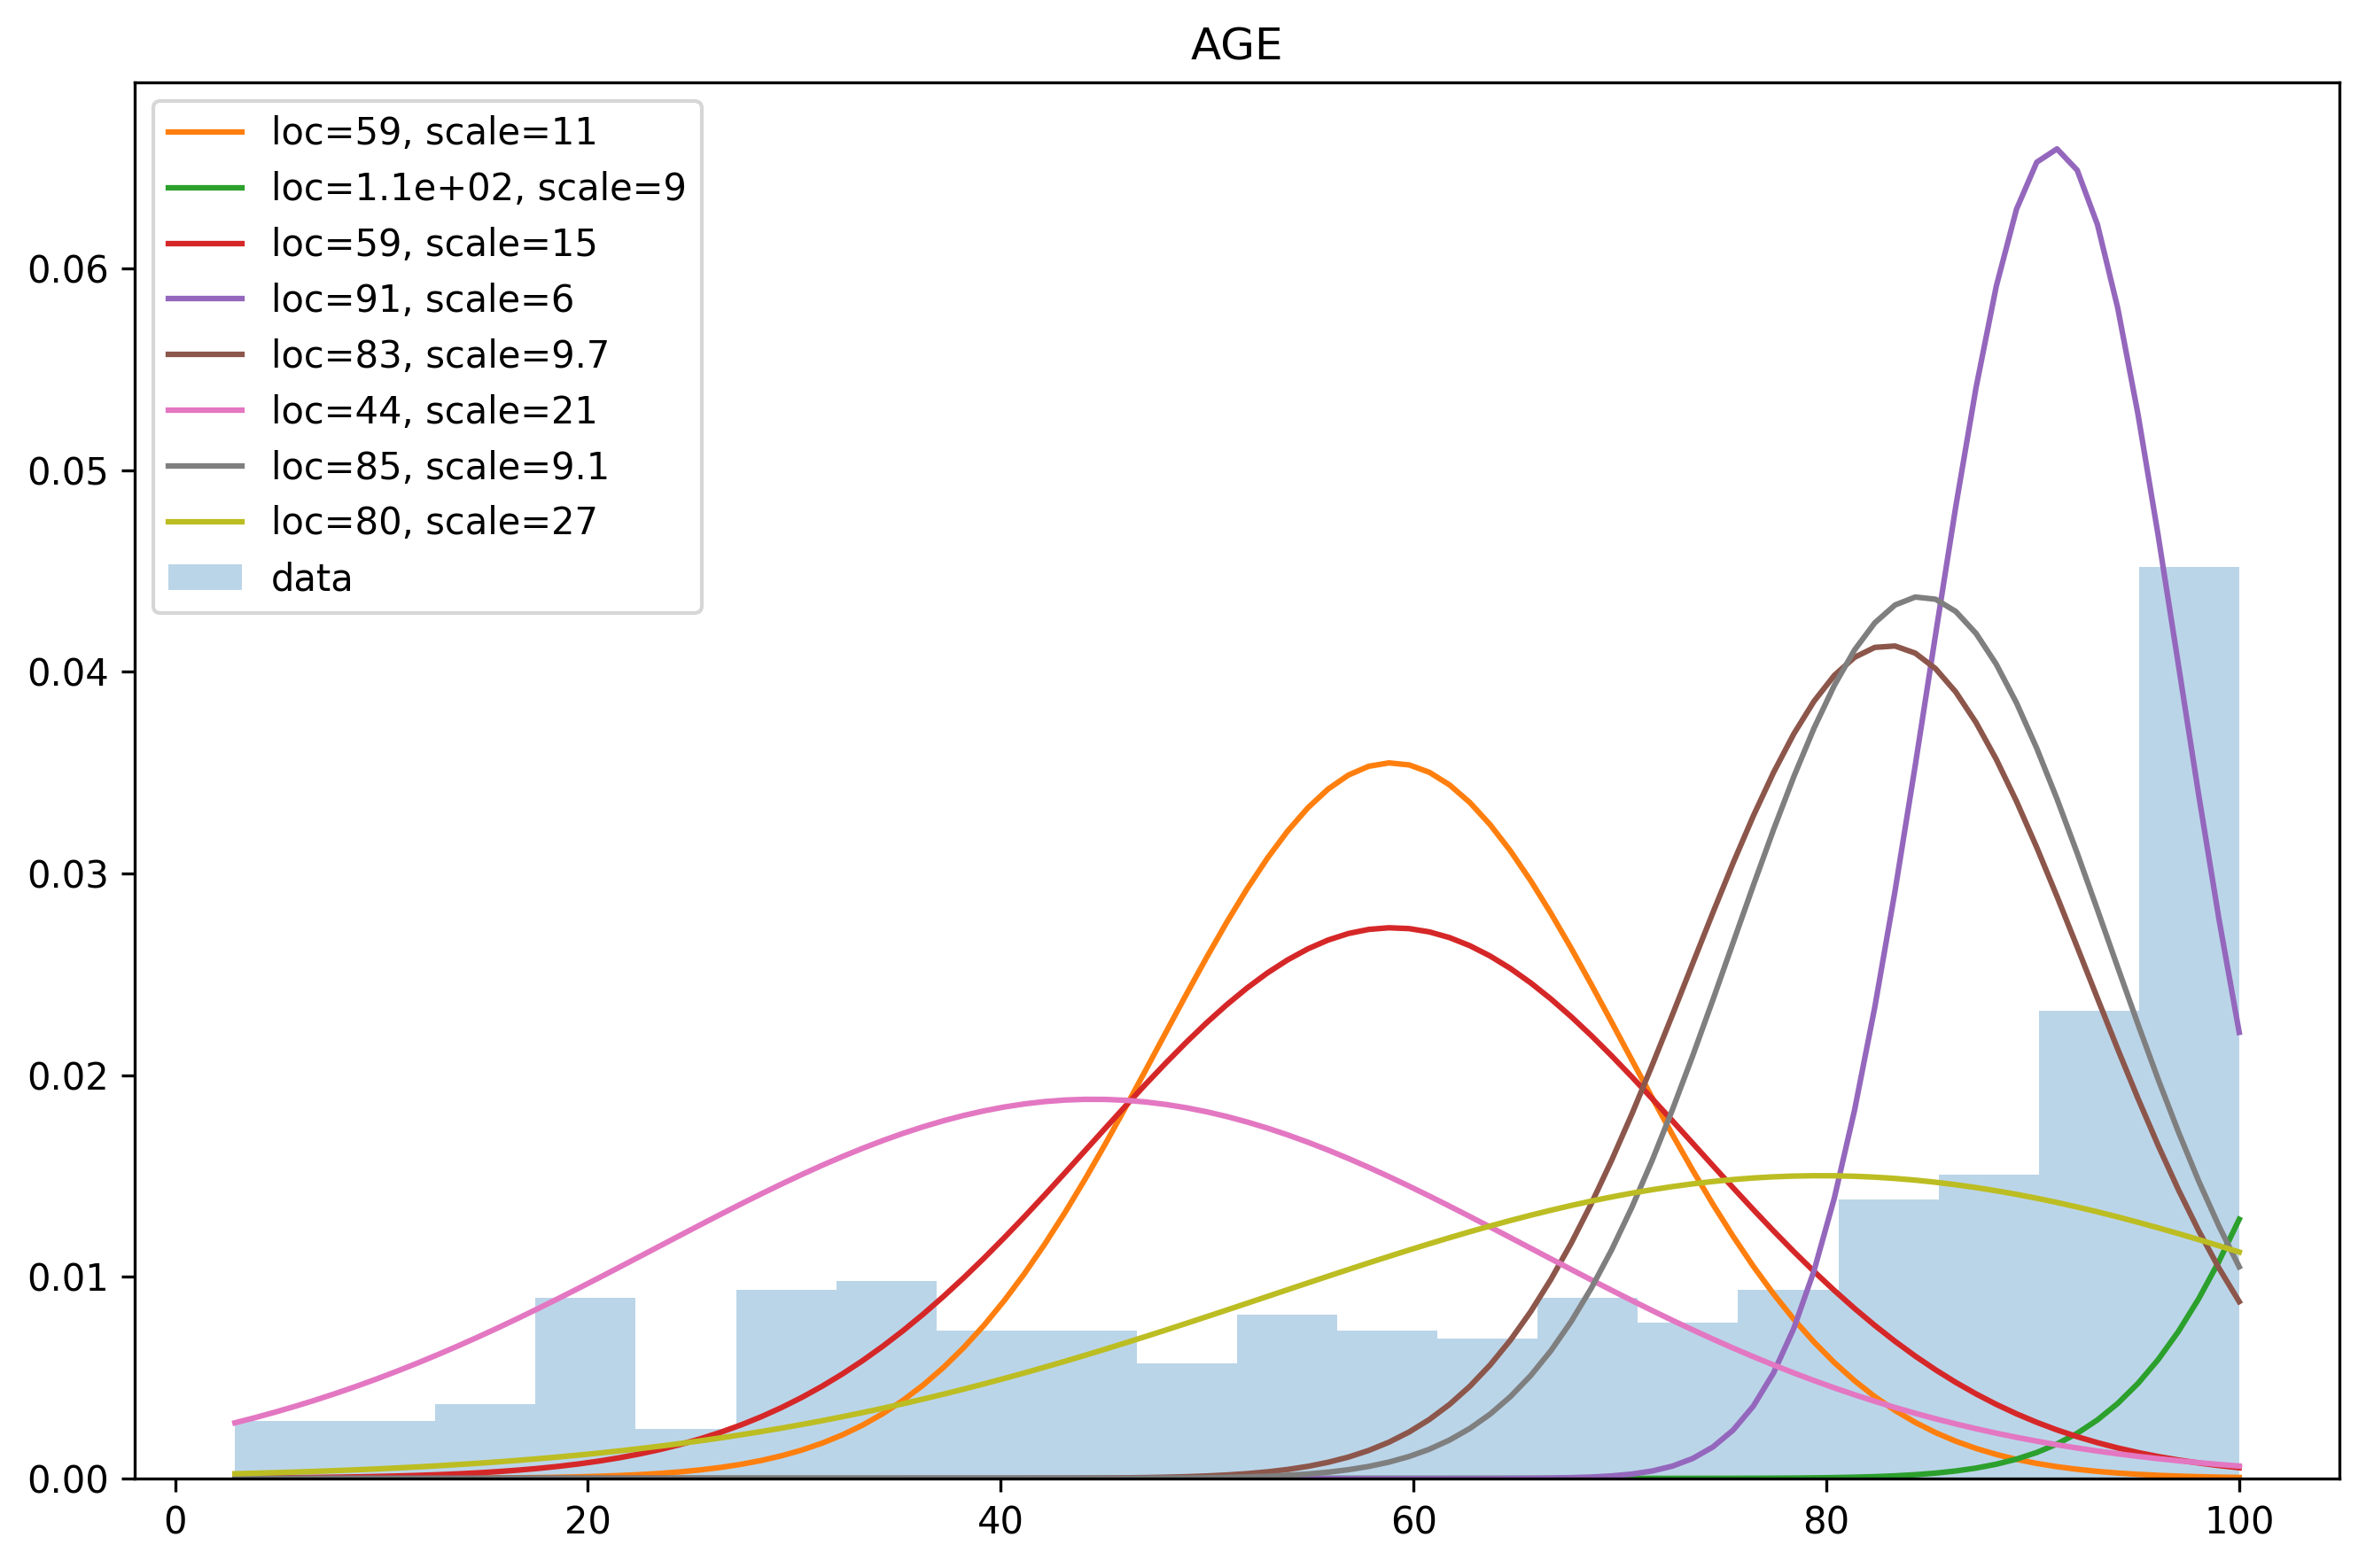

In [25]:
plot_feature(FEATURE)